## Week 6: Feedforward NN

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

#### ``Objectives``
1. Implement a feedforward NN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people. 

A deep-learning approach to predicting DR from eye images was proposed in 2016, in the paper <span style="color:chocolate">Development and Validation of a Deep Learning Algorithm for Detection of Diabetic Retinopathy in Retinal Fundus Photographs</span> published in JAMA.

Image source: https://www.sciencedirect.com/science/article/pii/S0010482513002862#f0005 



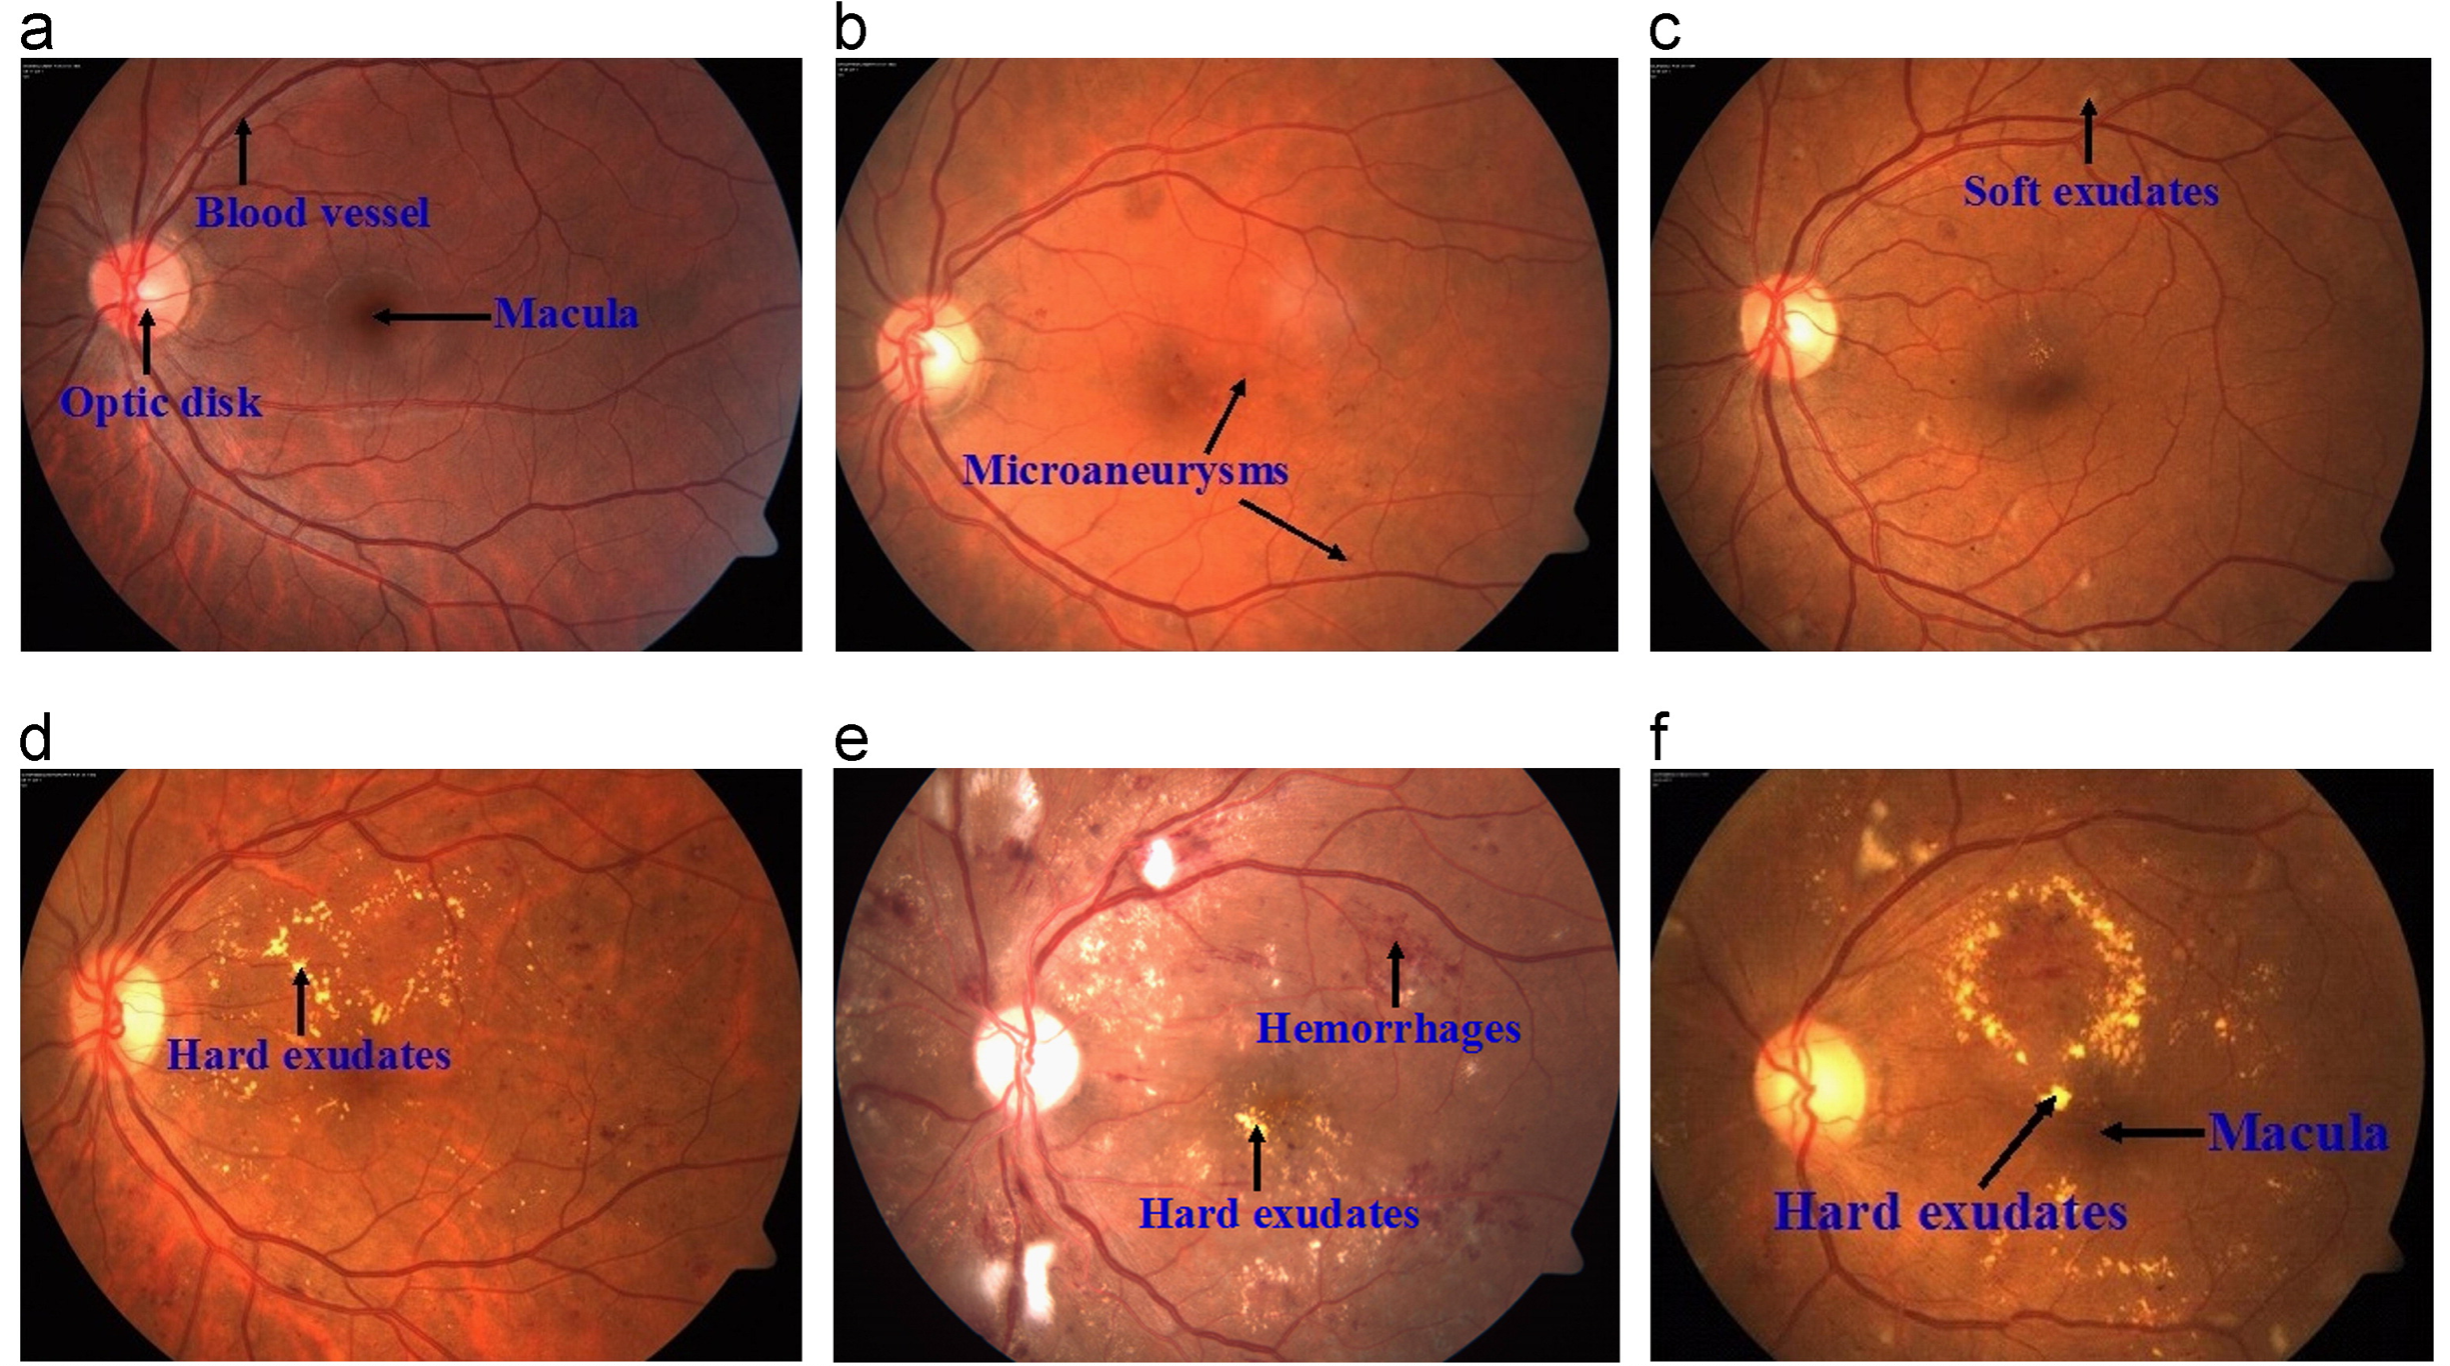

In [1]:
from IPython.display import Image
print('Image source: https://www.sciencedirect.com/science/article/pii/S0010482513002862#f0005 \n')
Image(filename='./images/DR.png', width=600) 

Typical fundus images: (a) Normal; (b) Mild DR; (c) Moderate DR; (d) Severe DR; (e) Prolific DR; (f) Macular edema. 


<span style="color:chocolate">Microaneurysms:</span> are tiny outpouchings of blood that protrude from an artery or vein. When they occur in the eye, they are known as retinal microaneurysms. If these protrusions open, they leak blood into the tissues of the retina

<span style="color:chocolate">Exuades:</span> a mass of cells and fluid that has seeped out of blood vessels or an organ, especially in inflammation.

<span style="color:chocolate">Macula:</span> an oval yellowish area surrounding the fovea near the center of the retina in the eye, which is the region of keenest vision

#### ``Data``

We will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a simple **NN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = '/Users/cilin/Postdoc/teaching/cilin-coursework-fall2022/Live_Sessions/week06/data/NN_images/' # replace with your path
LABEL_PATH = '/Users/cilin/Postdoc/teaching/cilin-coursework-fall2022/Live_Sessions/week06/data/NN_labels/' # replace with your path

ModuleNotFoundError: No module named 'shap'

## Read data

Let's now explore our dataset. We will start with label inspection and continue with image visualization.

In [3]:
y = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', y.shape)
print('Unique diagnosis codes:', np.sort(y.diagnosis.unique()))
y.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


id_code  diagnosis
0  000c1434d8d7          2
1  0024cdab0c1e          1
2  0083ee8054ee          4
3  00a8624548a9          2
4  00b74780d31d          2

There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


Image inspection:

Sample of images in data:


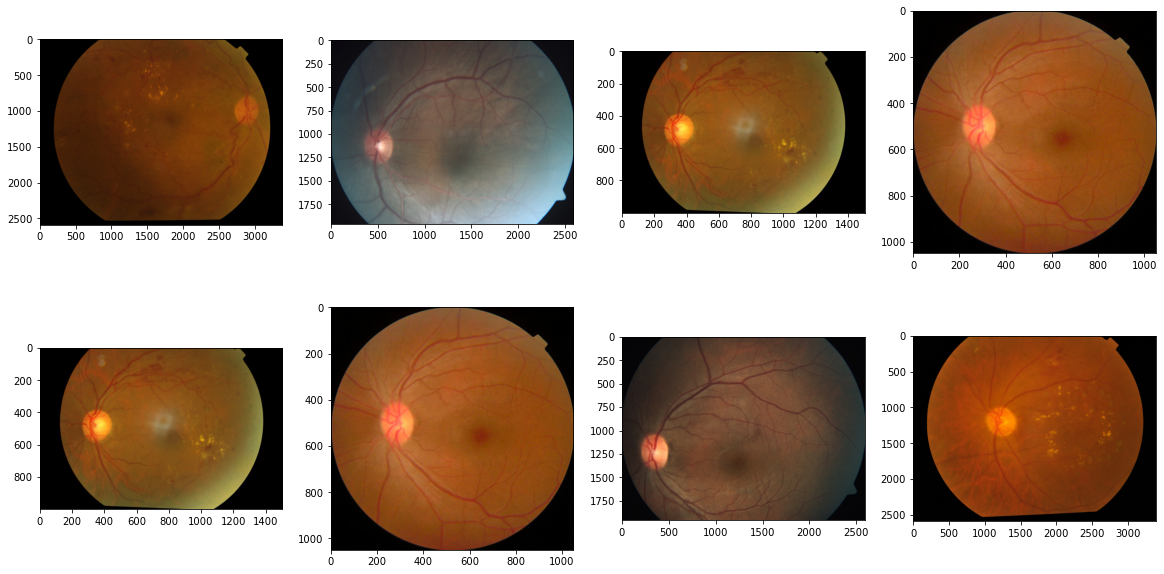

In [4]:
# read image
indx=0
images = []

print('Sample of images in data:')
for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

Like any real-world data set, you can see that these images have different sizes and focus. Later, you will use image transformation and data augmentation techniques to remove some of this variation.

## Data preprocessing

The quality of the data determines how well a machine learning algorithm can learn. This section will apply some simple techniques to deal with class imbalance. We will then create training/validation/test datasets and perform image transformation and augmentation.

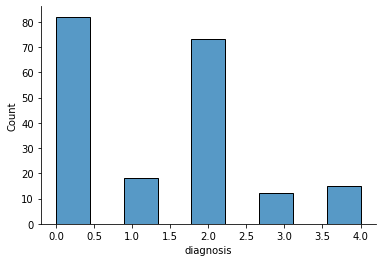

In [5]:
# histogram
sns.histplot(
    data=y,
    stat="count",
    x = "diagnosis"
);

sns.despine()

In [6]:
# compute percentage of the largest class
temp = y.groupby(
    'diagnosis',
    as_index=False
).id_code.count()

temp.rename(
    columns={'id_code':'counts'},
    inplace=True
)

temp['pct'] = temp.counts/temp.counts.sum()
print('Percentage of the largest class:',
      int(temp.pct.nlargest(n=1)[0]*100), '%'
     )

Percentage of the largest class: 41 %


---

`Correct for data imbalance`

As you can see from the histogram above, our dataset is very imbalanced, which is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for starters.

In [7]:
np.random.seed(1234)

no_refer = y[y.diagnosis.isin((0,1))]
refer = y[y.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))


Next, we will use the **preprocess_data_part1()** function defined below to generate lists of images and labels (`images_mini` and `y_mini`) based on the values in the temp_no_refer and temp_refer lists.

In [8]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [9]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH, LABEL_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


`Create train/validation/test data` and ``perform image tranformation and augmentation``

The next step in the data preprocessing part is to split the data into training, validation, and test sets. Once we have these partitions, we will apply image transformation and augmentations.


To give you an idea of what image transformation and augmentation do, let's see an example applied to the first image in our mini data.

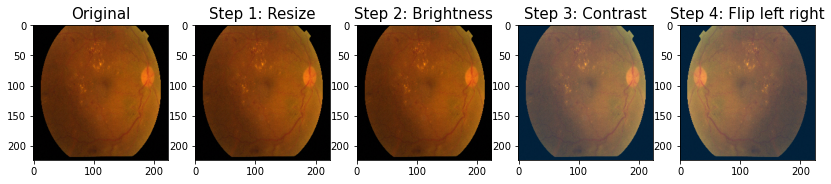

In [10]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

Next, we will define and run the **preprocess_data_part2()** function to create:

* train/validation/test sets with split (0.6,0.2,0.2)

* image transformation and augmentation, as follows:

<u>Applied on training, validation and test sets</u>:
  - resize to IMAGE_SIZE =(224,224) using tf.image.resize()
  - normalize all pixel values to the range (0,1)
  
<u>Applied on training set only</u> (note that this step will create additional/augmented copies of the training data):
  - adjust brightness by adding DELTA=0.3 to the pixel values using tf.image.adjust_brighness()
  - adjust contrast to CONTRAST_FACTOR=3 using tf.image.adjust_contrast()
  - flip left right using tf.image.flip_left_right()

The quantity and diversity of data gathered have a significant impact on the results of a neural net model. One can apply augmentations to artificially inflate the training dataset by warping the original data such that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [11]:
IMAGE_SIZE = (224, 224)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0

    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's sanity check our implementation of the preprocess_data_part2() function by printing the shape of (X,y) from train, validation and test sets.

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 1)
y_train shape (192,)
X_val shape (32, 224, 224, 1)
y_val shape (32,)
X_test shape (32, 224, 224, 1)
y_test shape (32,)


In [13]:
X_train[0][1][1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00464627], dtype=float32)>

Let's also print out the first 8 train and validation examples with the label of each example as the title.

Print training data examples:


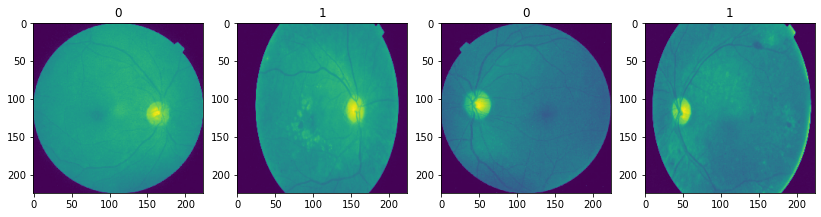

In [14]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


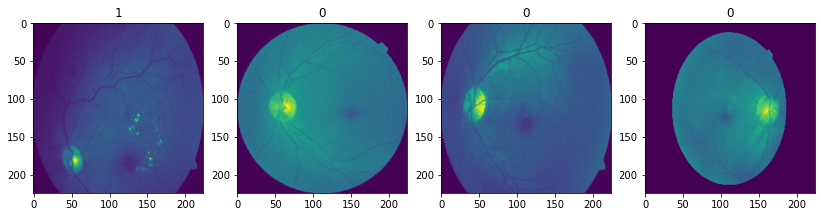

In [15]:
# print test data
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

## Model

Our objective is to build and train a FFNN model to refer patients to doctors based on the severity of DR seen in these images. We are interested in exploring binary classification of 'no refer' and 'refer'.

<u>The architecture of our NN model is as follows</u>:

1. the model receives input images of size 224 x 224 x 1
2. the input data goes through a flattening layer
3. the flatten input goes through three connected layers, followed by a dropout layer

For the dropout layer, we set the probability of dropping input units during training to 0.3.

We will implement this architecture using TensorFlow Keras API.

``Build model``

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# first layer: input
input1 = tf.keras.layers.Input(shape=(224, 224, 1), name='Input')

# second layer: flatten (transforms the format of the images (to a 1D array of 224*224 = 50176 pixels)
# this layer has no params or weights to learn, it only reformats data
input2 = tf.keras.layers.Flatten(name='Flatten')(input1)
    
# third layer: dense (i.e., the nodes are fully connected)
# this layer has 12544 nodes (112 x 112 image), and it uses the activation function Rectified Linear Unit
input3 = tf.keras.layers.Dense(units=12544, activation='relu', name='fc_1')(input2)
    
# forth layer: dense (i.e., the nodes are fully connected)
# this layer has 3136 nodes (56 x 56 image), and it uses the activation function Rectified Linear Unit
input4 = tf.keras.layers.Dense(units=3136, activation='relu', name='fc_2')(input3)
    
# fifth layer: dense (i.e., the nodes are fully connected)
# this layer has 784 nodes (28 x 28), and it uses the activation function Rectified Linear Unit
input5 = tf.keras.layers.Dense(units=784, activation='relu', name='fc_3')(input4)

# sixth layer: dropout
# makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
# This helps with computation time (less parameters) and with overfitting.
# each node in the third layer has a 0.3 probability of being dropped from the computation of the activations of the next layer. 
input6 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input5)

#the sixth (and last) layer, which is the output layer
# this last layer sets the activation function to "None" in order to output the logits 
# logits = natural logarithm of the odds ratio
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
out = tf.keras.layers.Dense(units=1, activation=None, name='fc_4')(input6)

# instantiate the model
model = tf.keras.models.Model(inputs=input1, outputs=out)

``Compile model``

The next step is to compile the model. We have to decide on the type of optimizer, loss function, and metrics to compute.

We will use the Adam optimizer, the most popular gradient-based optimization algorithm. There are a few other choices, and you can read more [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). The loss (cost) function suitable for our binary classification model is [binary_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses). We will compute model accuracy on the training, validation and test datasets.

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
              # ^ because our last layer does not apply sigmoid, by specifying from logits=True, the loss function applies the sigmoid function internally
              # ^ it's more efficient than doing it manually
              metrics=['accuracy']) # you can add other metrics here

``Fit model``

Finally, we will fit the model with 10 epochs on the train set and validate on the validation set. The performance depends on the current starter hyperparameters such as learning rate and choice of optimizer.

In [18]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val)
)

Epoch 1/10
6/6 [==============================] - 87s 14s/step - loss: 220.2268 - accuracy: 0.5156 - val_loss: 1.2521 - val_accuracy: 0.6250
Epoch 2/10
6/6 [==============================] - 110s 18s/step - loss: 8.9140 - accuracy: 0.4948 - val_loss: 1.2691 - val_accuracy: 0.5938
Epoch 3/10
6/6 [==============================] - 125s 21s/step - loss: 1.7624 - accuracy: 0.6875 - val_loss: 0.6216 - val_accuracy: 0.7812
Epoch 4/10
6/6 [==============================] - 119s 20s/step - loss: 0.6619 - accuracy: 0.7760 - val_loss: 0.5364 - val_accuracy: 0.7812
Epoch 5/10
6/6 [==============================] - 128s 22s/step - loss: 0.6187 - accuracy: 0.7760 - val_loss: 0.6517 - val_accuracy: 0.5938
Epoch 6/10
6/6 [==============================] - 124s 20s/step - loss: 0.4839 - accuracy: 0.8021 - val_loss: 0.5055 - val_accuracy: 0.8125
Epoch 7/10
6/6 [==============================] - 90s 15s/step - loss: 0.5226 - accuracy: 0.8177 - val_loss: 0.5575 - val_accuracy: 0.8125
Epoch 8/10
6/6 [====

Next let's plot loss and accuracy for training and validation sets

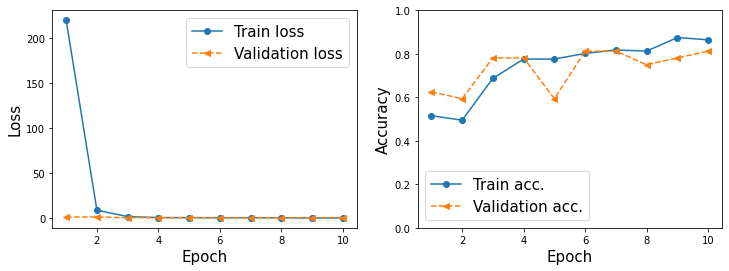

In [19]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

## Show what the NN model is learning after each layer

We will pick one example from our training data to visualize our NN model's learning after each layer. Below we print the original image.

Shape of image: (1, 224, 224, 1)


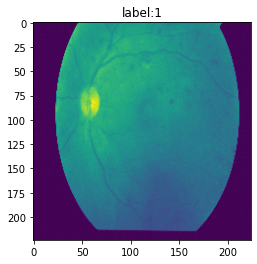

In [20]:
img_idx= 14
img_tensor = np.expand_dims(X_val[img_idx], axis = 0);

# Print image tensor shape
print('Shape of image:', img_tensor.shape);
  
# Print image (should be of shape 224 X 224)
plt.imshow(img_tensor[0]);
plt.title('label:' + str(y_val[img_idx]))
plt.show()

Next we print what the model learns after each layer. It's important to pay attention to the shape of the output image to understand what each layer does to the original input.

``print layers``

In [21]:
layers = [layer.output for layer in model.layers[:6]]
layers

[<KerasTensor: shape=(None, 224, 224, 1) dtype=float32 (created by layer 'Input')>,
 <KerasTensor: shape=(None, 50176) dtype=float32 (created by layer 'Flatten')>,
 <KerasTensor: shape=(None, 12544) dtype=float32 (created by layer 'fc_1')>,
 <KerasTensor: shape=(None, 3136) dtype=float32 (created by layer 'fc_2')>,
 <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'fc_3')>,
 <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'Dropout')>]

``activation model``

In [22]:
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layers)
activation_model

``data frames of learned activations for each layer``

In [23]:
activations = activation_model.predict(img_tensor)

## print to see what are the learned activations ##
##################################################
# original example
print('Feature values original example:')
display(pd.DataFrame(tf.squeeze(X_val[img_idx]).numpy()).head(3))

print('Learned activations first layer (should be the same as the original example, nothing to learn yet):')
# first layer (just flattening the 224x224 images to a 50176 array)
display(pd.DataFrame(activations[1].reshape(224,224)).head(3))

print('Learned activations second layer:')
# second layer (activate 12544 neurons (equivalent to 56 x 56 images)
display(pd.DataFrame(activations[2].reshape(112,112)).head(3))

print('Learned activations third layer:')
# second layer (activate 3136 neurons (equivalent to 56 x 56 images)
display(pd.DataFrame(activations[3].reshape(56,56)).head(3))

print('Learned activations forth layer:')
# second layer (activate 784 neurons (equivalent to 28 x 28 images)
display(pd.DataFrame(activations[4].reshape(28,28)).head(3))

Feature values original example:


0         1         2         3         4         5         6    \
0  0.010634  0.003921  0.006713  0.002791  0.003921  0.003921  0.006713   
1  0.003921  0.007842  0.003921  0.006713  0.002791  0.003921  0.003921   
2  0.003921  0.003921  0.007842  0.002791  0.006713  0.007842  0.003921   

        7         8         9    ...       214       215       216       217  \
0  0.007842  0.006713  0.003921  ...  0.003921  0.003921  0.003921  0.002791   
1  0.003921  0.006713  0.003921  ...  0.002791  0.003921  0.002791  0.010634   
2  0.003921  0.006713  0.003921  ...  0.001172  0.003921  0.002791  0.002791   

        218       219       220       221       222       223  
0  0.006713  0.003921  0.006713  0.011764  0.003921  0.003921  
1  0.006713  0.003921  0.006713  0.007842  0.007842  0.006713  
2  0.002791  0.011764  0.006713  0.003921  0.007842  0.002791  

[3 rows x 224 columns]

Learned activations first layer (should be the same as the original example, nothing to learn yet):


0         1         2         3         4         5         6    \
0  0.010634  0.003921  0.006713  0.002791  0.003921  0.003921  0.006713   
1  0.003921  0.007842  0.003921  0.006713  0.002791  0.003921  0.003921   
2  0.003921  0.003921  0.007842  0.002791  0.006713  0.007842  0.003921   

        7         8         9    ...       214       215       216       217  \
0  0.007842  0.006713  0.003921  ...  0.003921  0.003921  0.003921  0.002791   
1  0.003921  0.006713  0.003921  ...  0.002791  0.003921  0.002791  0.010634   
2  0.003921  0.006713  0.003921  ...  0.001172  0.003921  0.002791  0.002791   

        218       219       220       221       222       223  
0  0.006713  0.003921  0.006713  0.011764  0.003921  0.003921  
1  0.006713  0.003921  0.006713  0.007842  0.007842  0.006713  
2  0.002791  0.011764  0.006713  0.003921  0.007842  0.002791  

[3 rows x 224 columns]

Learned activations second layer:


0    1    2    3    4    5    6    7    8    9    ...  102  103  104  105  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   106  107  108  109  110  111  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 112 columns]

Learned activations third layer:


0    1    2    3    4    5    6         7    8    9   ...   46   47  \
0  0.273792  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...  0.0  0.0   
1  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.343226  0.0  0.0  ...  0.0  0.0   
2  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  ...  0.0  0.0   

    48   49   50   51        52        53   54   55  
0  0.0  0.0  0.0  0.0  1.500852  0.627838  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  

[3 rows x 56 columns]

Learned activations forth layer:


0    1         2        3    4    5         6    7         8    9   ...  \
0  0.0  0.0  0.000000  0.00000  0.0  0.0  1.828693  0.0  0.149621  0.0  ...   
1  0.0  0.0  0.000000  0.00000  0.0  0.0  0.000000  0.0  0.000000  0.0  ...   
2  0.0  0.0  2.873415  1.24453  0.0  0.0  0.000000  0.0  0.000000  0.0  ...   

    18        19        20   21        22        23   24        25   26  \
0  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
1  0.0  0.437463  1.158123  0.0  1.099606  2.068243  0.0  1.931494  0.0   
2  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   

         27  
0  1.393755  
1  0.000000  
2  0.000000  

[3 rows x 28 columns]

``images of learned activations for each layer``

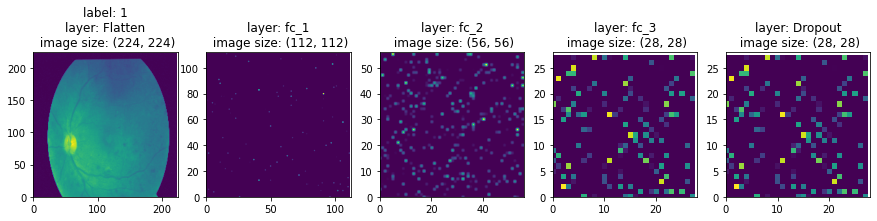

In [24]:
fig, axes = plt.subplots(1, 5, sharey=False, figsize=(15, 25))
                                                    

for idx, ax in enumerate(axes.flatten()):
    # save activation and shape
    activation = activations[idx+1]
    shape = int(np.sqrt(activation.shape)[1]), int(np.sqrt(activation.shape)[1])

    # plot activation
    ax.imshow(activation.reshape(shape))
    ax.set_xlim(0, shape[0])
    ax.set_ylim(0, shape[0])
    
    if idx==0:
        ax.set_title('label: ' + str(y_val[img_idx]) +
                     '\nlayer: ' + layers[idx+1].name.split('/')[0] +
                     '\n image size: ' +  str(activation.reshape(shape).shape))
    else:
        ax.set_title('\nlayer: ' + layers[idx+1].name.split('/')[0] +
                     '\n image size: ' +  str(activation.reshape(shape).shape))
plt.show()

``Can we do better in terms of model interpretability? YES!``

<span style="color:chocolate">Explainable AI/ML using Shap</span>

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see [here](https://github.com/slundberg/shap#citations) and [here](https://shap.readthedocs.io/en/latest/overviews.html) and [here](https://databricks.com/fr/wp-content/uploads/2019/10/Introduction-to-Neural-Networks-MLflow-and-SHAP.html)).

We will use SHAP to explain the predictions made by our model on the validation image at index==img_idx using GradientExplainer.

In [25]:
# define the explainer
explainer = shap.GradientExplainer(model, X_train.numpy())

# we explain the model's predictions on the validation image at index==img_idx
shap_values = explainer.shap_values(X_val[img_idx:img_idx+1].numpy())

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


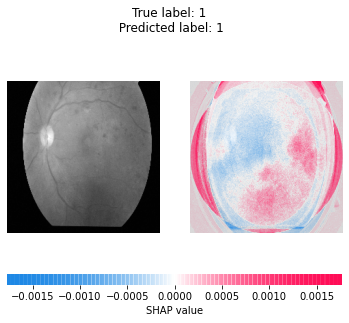

In [26]:
# plot the explanations for all classes (well, binary outcome)
shap.image_plot(
    [shap_values[i][0] for i in range(1)],
    np.squeeze(X_val[img_idx]),
    show=False
)

# compute predicted label for X_val[img_idx]
y_val_pred_img_idx = np.where(tf.sigmoid(model.predict(X_val)[img_idx])>=0.5, 1, 0)

# add title
plt.suptitle(
    'True label: ' + str(y_val[img_idx]) +
    '\n Predicted label: ' + str(y_val_pred_img_idx[0]));

The plot above shows the SHAP explanations for the X_val[img_idx] example. On the LHS is the original image. Red pixels increase the model's output. Blue pixels decrease the model's output.

## Evaluation

Evaluation is one of the most important parts of machine learning as it helps us determine how good our trained model is in predicting unseen data.

Notice that (`X_test`, and `y_test`) were not used in the training part. It would be very bad practice to evaluate the model on the test set, and then return and update the model based on those results (then the test set is acting like just another validation set). 

We will now use our test data to evaluate the performance (accuracy) of our NN model on unseen data. Note that accuracy is the default metric if one compiles the model with the accuracy metric.

In [27]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

1/1 [==============================] - 0s 394ms/step - loss: 0.5199 - accuracy: 0.8125

Test Acc. 81.25%


`get predictions results in the form of class-membership probabilities`

In the following figure, you can see all the images in the test data along with their ground truth (GT) labels and the predicted probabiliy that they belong to class 1, 'Refer' 

In [28]:
# transform logits to probabilities
pred_logits = model.predict(X_test)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

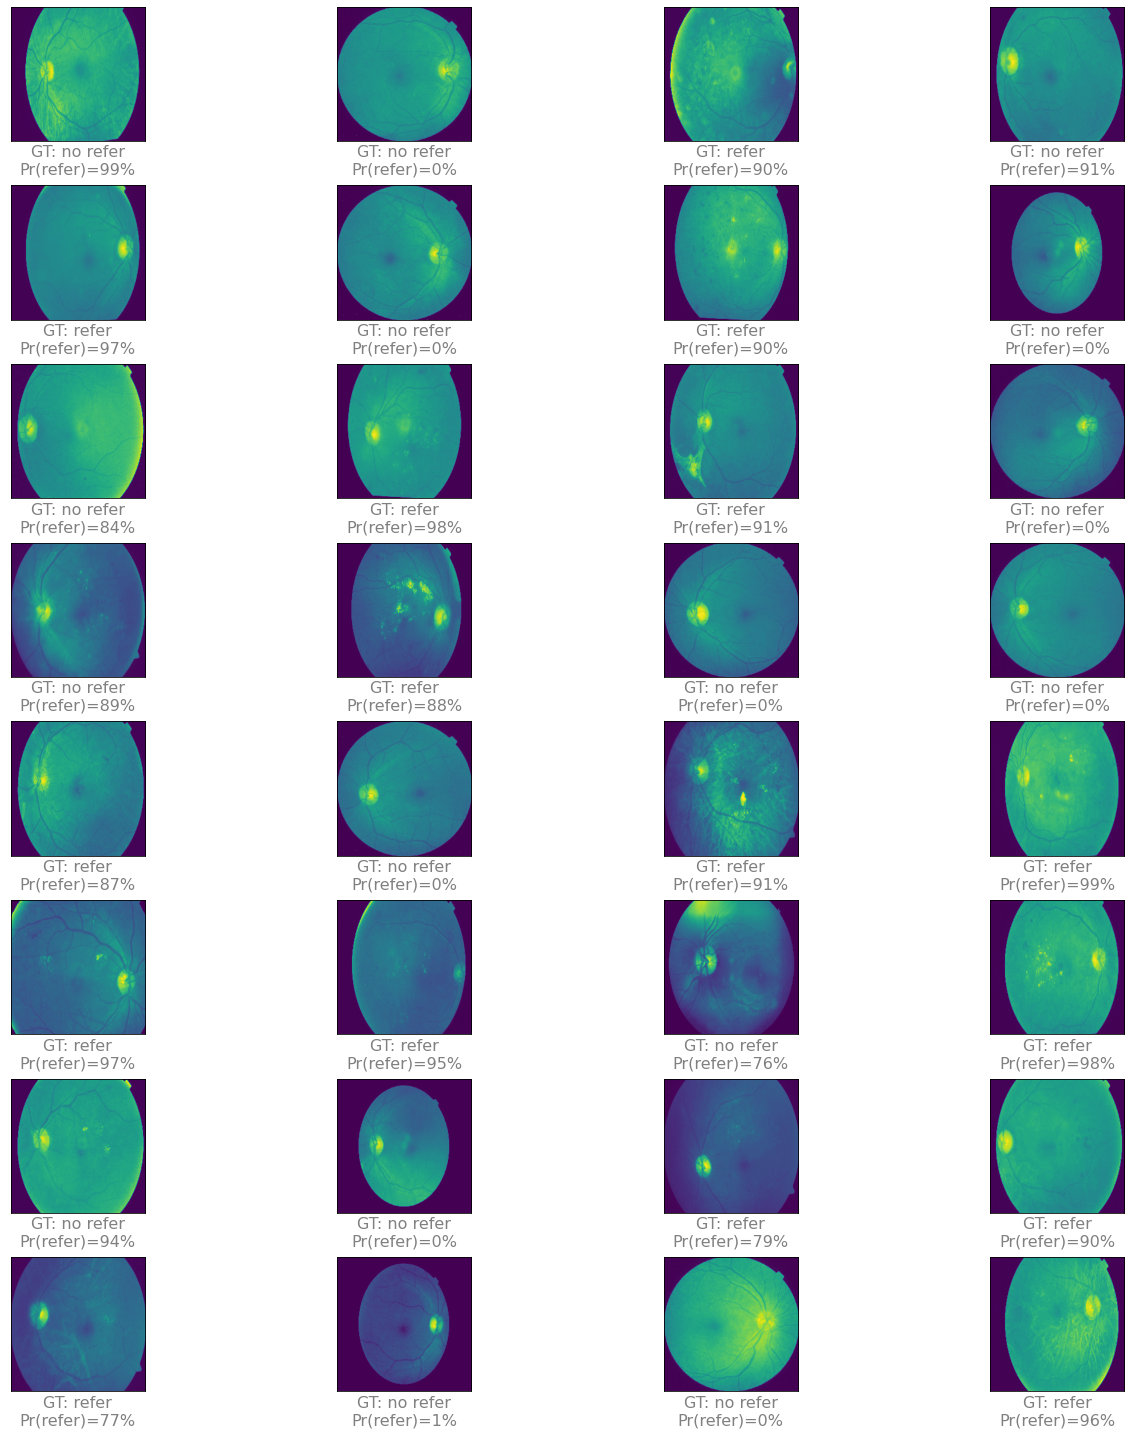

In [29]:
# plot test data and associated predicred
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(X_test):
    ax = fig.add_subplot(8,4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='no refer'
    else:
        label='refer'
    
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(refer)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()